# Are we flattening the curve?

Something I haven't seen discussed elsewhere is whether the announced restrictions are having an effect, *after they have fully propagated throughout society*. For example, upon announcing a restriction on public gatherings, there are still members of society who are infected but will not show symptoms until several days after the restriction is in place. There is effectively an "incubation period" between an announcement, and when we can be confident all new infections have occurred post-announcement. My analysis below takes this incubation period into account.

Update Apr 03: Since writing this analysis it has been cited in articles by [The Guardian](https://www.theguardian.com/australia-news/datablog/2020/apr/01/is-australia-flattening-the-coronavirus-curve-look-at-the-charts-) and [News Corp](https://www.news.com.au/lifestyle/health/health-problems/coronavirus-australia-the-10-days-it-takes-to-know-if-socialdistancing-works/news-story/e9dbc6ef2e78eb132cbc17ce4793601f). Hopefully it has helped some people out there with the same questions as me!

I have modelled this incubation period based on the [NSW Health FAQ](https://www.health.nsw.gov.au/Infectious/alerts/Pages/coronavirus-faqs.aspx):

> The time between when a person is exposed to the virus and when symptoms first appear is typically 5 to 6 days, although may range from 2 to 14 days. For this reason, people who might have been in contact with a confirmed case are being asked to self-isolate for 14 days.





In [0]:
incubation_period = 6 # days

Some other key parameters are configured below:

In [0]:
# Start date? Start from March since the data is pretty scattered before then
start_date = '2020-03-01'
# Which state? NSW, since that's where I live
state_of_interest = 'NSW'
# Fill missing counts with previous day?
# Not ideal, since it often makes the curve artifically flat for the current day
# But new counts don't always get posted every 24 hours unfortunately
fill_missing_days = True
# Skip today's data? Another means of accounting for the delay in updating counts
skip_today = True

In [0]:
#@title Init
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://github.com/pandas-dev/pandas/issues/18301#issuecomment-573313229
pd.plotting.register_matplotlib_converters()

Data is sourced from this excellent [Guardian article by Nick Evershed](https://www.theguardian.com/news/datablog/ng-interactive/2020/mar/23/how-many-cases-of-coronavirus-are-there-in-australia-live-statistics):

In [0]:
# Source: https://www.theguardian.com/news/datablog/ng-interactive/2020/mar/23/how-many-cases-of-coronavirus-are-there-in-australia-live-statistics
base = pd.read_json('https://interactive.guim.co.uk/docsdata/1q5gdePANXci8enuiS4oHUJxcxC13d6bjMRSicakychE.json')

In [0]:
#@title Data loading / cleaning

updates = base.sheets.updates
updates_table = pd.json_normalize(updates)

# parse dates as datetimes
updates_table['Date'] = pd.to_datetime(updates_table['Date'], format='%d/%m/%Y')
# convert case counts to numeric (strip commas)
updates_table['Cumulative case count'] = pd.to_numeric(updates_table['Cumulative case count'].str.replace(',', ''))

# strip to columns of interest only
cases_by_state = updates_table[['State', 'Date', 'Cumulative case count']]

# looks like there are some duplicate entries, especially for some of the early days
# just pick one entry to de-dupe
unique_cases_by_state = cases_by_state.drop_duplicates(subset=['State', 'Date'], keep='first')

# Pivot the data so we have case counts per state per day
p = unique_cases_by_state.pivot(index='Date', columns='State', values='Cumulative case count')

# Fill in the missing days
all_days = pd.date_range(p.index.min(), p.index.max())
p2 = p.reindex(all_days)
p2.index.name = p.index.name
p = p2

# Fill in blanks with previous day's count
if fill_missing_days:
  p = p.ffill() 

In [6]:
# What's the most recent data we have?
print(p.sort_values(by='Date')[-5:])

State         ACT     NSW    NT    QLD     SA    TAS     VIC     WA
Date                                                               
2020-04-10  103.0  2847.0  28.0  965.0  427.0  111.0  1241.0  506.0
2020-04-11  103.0  2857.0  28.0  972.0  428.0  122.0  1265.0  514.0
2020-04-12  102.0  2863.0  28.0  983.0  429.0  144.0  1268.0  517.0
2020-04-13  103.0  2863.0  28.0  987.0  431.0  150.0  1281.0  523.0
2020-04-14  103.0  2870.0  28.0  998.0  431.0  150.0  1291.0  523.0


In [0]:
# Here are our highlighted restrictions, sourced from PMO Media Releases
# They are my best guess at which restrictions are most significant
highlights = [\
              # https://www.pm.gov.au/media/update-novel-coronavirus-covid-19-australia
              ['2020-03-01', 'Iran + China arrivals blocked'], \
              
              # https://www.pm.gov.au/media/advice-coronavirus
              # NB: technically this became effective 16th, but
              # the announcement itself may have been enough to 
              # trigger some behaviour modification
              ['2020-03-13', 'Outdoor gatherings limited to 500 persons'],\
              
              # https://www.pm.gov.au/media/coronavirus-measures-endorsed-national-cabinet
              ['2020-03-16', 'Self-isolation for overseas travellers, cruise ships blocked for 30 days'],\
              
              # https://www.pm.gov.au/media/update-coronavirus-measures
              ['2020-03-18', 'Indoor gatherings limited to 100 persons, outdoors still 500'],\
             
              # https://www.pm.gov.au/media/border-restrictions
              ['2020-03-19', 'Borders closed to non-citizens and residents'],\

              # https://www.pm.gov.au/media/update-coronavirus-measures-220320
              ['2020-03-23', 'Pubs / clubs closed, restaurants take-away only', '-1 Day'],\
              
              # https://www.pm.gov.au/media/update-coronavirus-measures-24-March-2020
              ['2020-03-24', 'Ban on Australians travelling overseas'],\

              # https://www.pm.gov.au/media/national-cabinet-update
              ['2020-03-26', 'Expanded testing criteria', '-0.5 day'],\

              # https://www.pm.gov.au/media/update-coronavirus-measures-270320
              ['2020-03-28', 'Mandatory isolation in hotels for all travellers', '-1 Day'],\

              # https://www.pm.gov.au/media/national-cabinet-statement
              ['2020-03-30', 'Outdoor / indoor gatherings 2 persons only', '-1 Day']
             ]

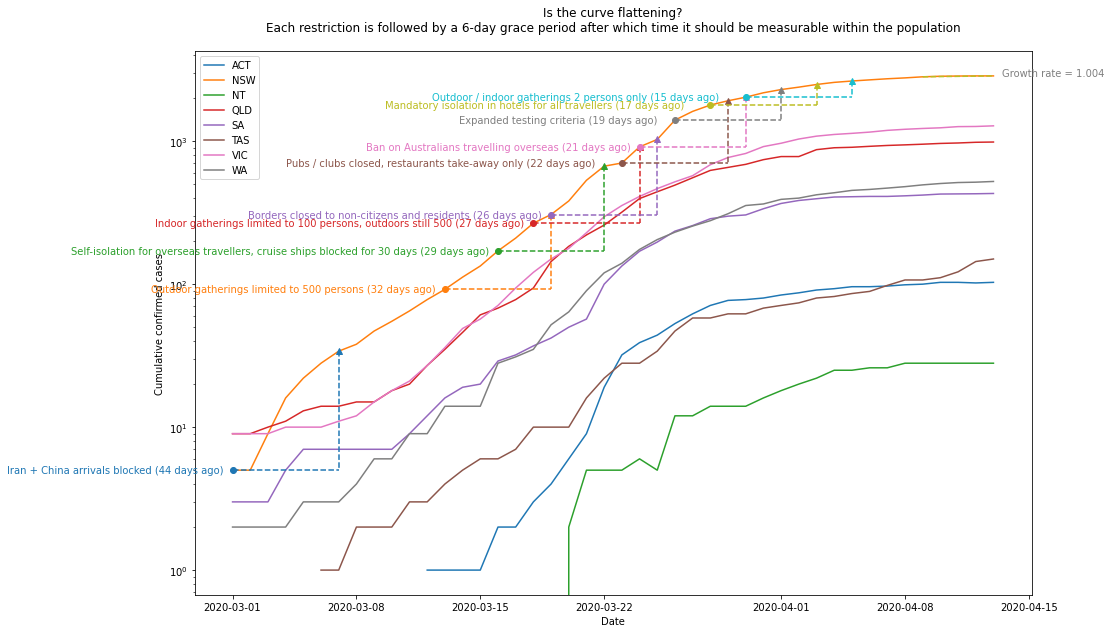

In [8]:
# Time to plot...

# Take only data since our configured start date
sample_data = p[start_date:]
if skip_today:
  sample_data = sample_data[:-1]

plt.figure(figsize=[15,10])
plt.yscale('log')
plt.xscale('linear')
plt.title('Is the curve flattening?\n\
Each restriction is followed by a {0}-day grace period after which \
time it should be measurable within the population'.format(incubation_period), pad=20)
plt.xlabel('Date')
plt.ylabel('Cumulative confirmed cases')

# Plot each state's data
for col in sample_data.columns:
    plt.plot(sample_data[col], label=col)

# For each highlight, annotate the graph and shade the values for 14 days
# to suggest when the effect is taking place
now = pd.Timestamp.today()
for index, (date_str, action, *etc) in enumerate(highlights):
    highlight_start = pd.Timestamp(date_str)
    days_ago = (now - highlight_start).days
    action = "{0} ({1} days ago)".format(action, days_ago)

    # Add a dashed line across / up for each one
    range = sample_data[state_of_interest][highlight_start:][:incubation_period + 1]
    date_start = range.index[0]
    value_start = range[0]
    date_end = range.index[-1]
    value_end = range[-1]

    colour = 'C{0}'.format(index % 10)
    style_start = 'o--{0}'.format(colour)
    style_end = '^--{0}'.format(colour)
    alpha=1
    # Horizontal dashed line from the start of the restriction
    plt.plot([date_start, date_end], [value_start, value_start], style_start, markevery=2, alpha=alpha)
    if (days_ago >= incubation_period):
      # Grace period is over, add vertical line indicating end of the period
      plt.plot([date_end, date_end], [value_end, value_start], style_end, markevery=2, alpha=alpha)

    # Add the annotation, a little to the left of the start point
    offset_str = etc[0] if etc else '0 days'
    offset = pd.Timedelta(offset_str) # manual offset to minimise overlapping
    text_start = date_start + pd.Timedelta('-12 hours') + offset
    plt.text(text_start, value_start, action, horizontalalignment='right', verticalalignment='center', color=colour, alpha=alpha)

# Let's add a growth rate, last 5 days
growth_sample_days = 5
compound = growth_sample_days - 1 # of days growth is compounded
range = sample_data[state_of_interest]
range_start = range[-growth_sample_days]
range_start_date = range.index[-growth_sample_days]
range_end = range[-1]
range_end_date = range.index[-1]
growth = range_end / range_start
daily_growth = growth ** (1 / compound)
daily_growth = round(daily_growth, 3)
plt.plot([range_start_date, range_end_date], [range_start, range_end], '--', markerfacecolor='gray')
plt.text(range_end_date +  + pd.Timedelta('12 hours'), range_end, 'Growth rate = {0}'.format(daily_growth), color='gray')

plt.legend(loc="upper left")
plt.show()

# NB: might be some warnings below, depending on how complete today's data is

# What About New Cases Per Day?

The [official government statistics](https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-current-situation-and-case-numbers) report the latest cumulative totals for each state. Therefore, if we take the difference between yesterday's total and today's, we can calculate new cases per day, which is another useful rate-of-change measure.

In [9]:
# new cases = today's total - yesterday's total, for all days
yesterday = sample_data.copy()
yesterday.index = [i + pd.Timedelta('1 day') for i in yesterday.index]
new_cases = (sample_data - yesterday)[:-1]
new_cases.index.name = 'Date'

print(new_cases[-5:])

State       ACT   NSW   NT   QLD   SA   TAS   VIC    WA
Date                                                   
2020-04-09  1.0  49.0  0.0  10.0  5.0   0.0  16.0  14.0
2020-04-10  3.0  25.0  0.0  12.0  7.0   4.0  13.0  11.0
2020-04-11  0.0  10.0  0.0   7.0  1.0  11.0  24.0   8.0
2020-04-12 -1.0   6.0  0.0  11.0  1.0  22.0   3.0   3.0
2020-04-13  1.0   0.0  0.0   4.0  2.0   6.0  13.0   6.0


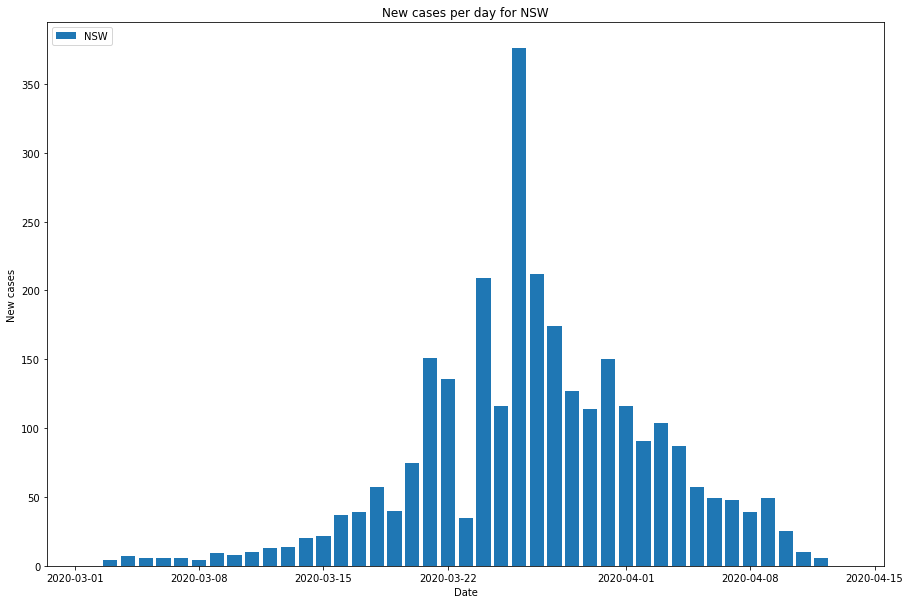

In [10]:
# Time to plot...

plt.figure(figsize=[15, 10])
plt.bar(new_cases[state_of_interest].index, new_cases[state_of_interest], label=state_of_interest)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('New cases')
plt.title('New cases per day for {}'.format(state_of_interest))
plt.show()